In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

In [2]:
class MathDecisionGate(nn.Module):
    def __init__(self, input_size, hidden_size, operations=None):
        super().__init__()
        self.operations = operations or ['add', 'mul']
        self.op_selector = nn.Linear(input_size, len(self.operations))
        self.operation_layers = nn.ModuleDict()
        
        for op in self.operations:
            self.operation_layers[op] = nn.Linear(input_size, hidden_size)

    def forward(self, x, temperature=1.0, hard=False):
        logits = self.op_selector(x)
        op_weights = F.gumbel_softmax(logits, tau=temperature, hard=hard)
        outputs = []

        for i, op in enumerate(self.operations):
            out = torch.tanh(self.operation_layers[op](x))
            outputs.append(op_weights[:, i:i+1] * out)
        return sum(outputs)


In [3]:
class SymbolicRNNCell(nn.Module):
    def __init__(self, input_size, hidden_size, operations=None):
        super().__init__()
        self.hidden_size = hidden_size
        self.math_gate = MathDecisionGate(input_size + hidden_size, hidden_size, operations)

    def forward(self, x, h, temperature=1.0, hard=False):
        combined = torch.cat([x, h], dim=1)
        h_next = self.math_gate(combined, temperature=temperature, hard=hard)
        return h_next


In [4]:
class SymbolicEquationModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=32, output_size=2, operations=None):
        super().__init__()
        self.rnn_cell = SymbolicRNNCell(input_size=2, hidden_size=hidden_size, operations=operations)
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x, y, temperature=1.0, hard=False):
        batch_size, seq_len, _ = x.size()
        h = torch.zeros(batch_size, self.rnn_cell.hidden_size)
        
        for t in range(seq_len):
            xt = torch.cat([x[:, t], y[:, t]], dim=1)
            h = self.rnn_cell(xt, h, temperature=temperature, hard=hard)
        return self.output_layer(h)


In [5]:
def generate_dataset(num_samples=100, equation_type="linear"):
    x = np.random.uniform(-5, 5, size=(num_samples, 1))
    if equation_type == "linear":
        a, b = np.random.uniform(-5, 5), np.random.uniform(-5, 5)
        y = a * x + b
        coeffs = np.array([a, b])
    elif equation_type == "quadratic":
        a, b, c = np.random.uniform(-2, 2, size=3)
        y = a * x**2 + b * x + c
        coeffs = np.array([a, b, c])
    elif equation_type == "sine":
        a, b = np.random.uniform(0.5, 2), np.random.uniform(-2, 2)
        y = a * np.sin(x) + b
        coeffs = np.array([a, b])
    return torch.tensor(x, dtype=torch.float32), torch.tensor(y, dtype=torch.float32), torch.tensor(coeffs, dtype=torch.float32)

In [6]:
import matplotlib.pyplot as plt

def train_model(
    model, 
    epochs=200, 
    batch_size=32, 
    seq_len=20, 
    lr=0.01, 
    start_temp=1.0, 
    end_temp=0.1, 
    equation_type="linear"
):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.MSELoss()

    # Linearly decreasing temperature
    temp_schedule = np.linspace(start_temp, end_temp, epochs)
    loss_log = []

    for epoch in range(epochs):
        # Create a new batch of synthetic data
        x_raw, y_raw, coeffs = generate_dataset(num_samples=seq_len * batch_size, equation_type=equation_type)
        x = x_raw.view(batch_size, seq_len, 1)
        y = y_raw.view(batch_size, seq_len, 1)
        true_coeffs = coeffs.unsqueeze(0).repeat(batch_size, 1)

        temperature = temp_schedule[epoch]
        model.train()
        optimizer.zero_grad()

        pred_coeffs = model(x, y, temperature=temperature, hard=False)
        loss = criterion(pred_coeffs, true_coeffs)
        loss.backward()
        optimizer.step()

        loss_log.append(loss.item())

        if (epoch + 1) % 20 == 0 or epoch == 0:
            print(f"Epoch {epoch+1}/{epochs} | Loss: {loss.item():.6f} | Temp: {temperature:.4f}")

    # Plot training loss
    plt.plot(loss_log)
    plt.title("Training Loss Over Epochs")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid(True)
    plt.show()

    return model


In [8]:
def evaluate_model(model, seq_len=20, batch_size=1, equation_type="linear", temperature=0.1):
    model.eval()
    with torch.no_grad():
        x_raw, y_raw, true_coeffs = generate_dataset(num_samples=seq_len * batch_size, equation_type=equation_type)
        x = x_raw.view(batch_size, seq_len, 1)
        y = y_raw.view(batch_size, seq_len, 1)

        pred_coeffs = model(x, y, temperature=temperature, hard=True).squeeze().numpy()
        true_coeffs = true_coeffs.numpy()

        print(f"\n🔢 True coefficients ({equation_type}):")
        print(true_coeffs)

        print(f"\n🤖 Predicted coefficients:")
        print(pred_coeffs)

    return pred_coeffs, true_coeffs, x_raw.numpy(), y_raw.numpy()


Epoch 1/1000 | Loss: 4.773481 | Temp: 1.0000
Epoch 20/1000 | Loss: 7.524455 | Temp: 0.9829
Epoch 40/1000 | Loss: 3.355769 | Temp: 0.9649
Epoch 60/1000 | Loss: 3.342361 | Temp: 0.9468
Epoch 80/1000 | Loss: 5.348749 | Temp: 0.9288
Epoch 100/1000 | Loss: 1.723522 | Temp: 0.9108
Epoch 120/1000 | Loss: 2.181564 | Temp: 0.8928
Epoch 140/1000 | Loss: 10.767225 | Temp: 0.8748
Epoch 160/1000 | Loss: 9.767449 | Temp: 0.8568
Epoch 180/1000 | Loss: 13.479216 | Temp: 0.8387
Epoch 200/1000 | Loss: 4.551769 | Temp: 0.8207
Epoch 220/1000 | Loss: 1.631096 | Temp: 0.8027
Epoch 240/1000 | Loss: 5.679761 | Temp: 0.7847
Epoch 260/1000 | Loss: 2.951995 | Temp: 0.7667
Epoch 280/1000 | Loss: 6.196510 | Temp: 0.7486
Epoch 300/1000 | Loss: 4.297252 | Temp: 0.7306
Epoch 320/1000 | Loss: 3.638151 | Temp: 0.7126
Epoch 340/1000 | Loss: 3.038009 | Temp: 0.6946
Epoch 360/1000 | Loss: 5.499030 | Temp: 0.6766
Epoch 380/1000 | Loss: 3.596054 | Temp: 0.6586
Epoch 400/1000 | Loss: 4.104949 | Temp: 0.6405
Epoch 420/1000 | 

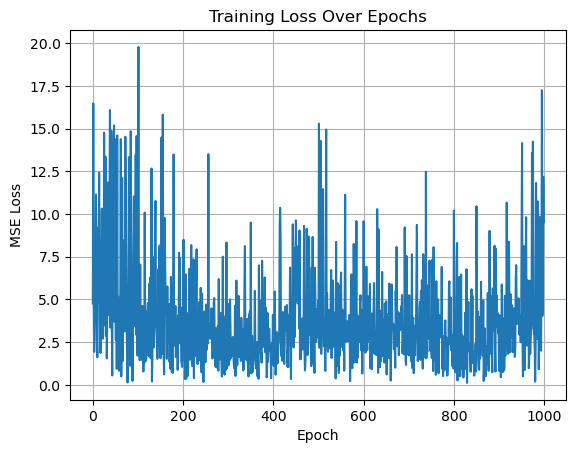


🔢 True coefficients (linear):
[-2.4275281 -4.4967146]

🤖 Predicted coefficients:
[ 0.9299299 -1.6511899]


(array([ 0.9299299, -1.6511899], dtype=float32),
 array([-2.4275281, -4.4967146], dtype=float32),
 array([[ 2.6661708 ],
        [ 1.8587903 ],
        [-0.4850215 ],
        [ 0.8829885 ],
        [-1.5722883 ],
        [ 1.8648975 ],
        [ 4.559025  ],
        [-2.9358974 ],
        [ 0.46543142],
        [ 2.2935038 ],
        [-3.0904818 ],
        [-3.0107145 ],
        [-3.013454  ],
        [ 1.9297231 ],
        [ 3.9507325 ],
        [-1.6697206 ],
        [ 1.1855322 ],
        [-1.6357466 ],
        [ 1.9366876 ],
        [-1.330536  ]], dtype=float32),
 array([[-10.96892   ],
        [ -9.008981  ],
        [ -3.3193114 ],
        [ -6.6401944 ],
        [ -0.6799406 ],
        [ -9.023806  ],
        [-15.563876  ],
        [  2.6302588 ],
        [ -5.6265626 ],
        [-10.06426   ],
        [  3.0055165 ],
        [  2.8118796 ],
        [  2.8185298 ],
        [ -9.181172  ],
        [-14.087229  ],
        [ -0.4434208 ],
        [ -7.3746276 ],
        [ -0.5258

In [12]:
model = SymbolicEquationModel(input_size=1, hidden_size=32, output_size=2, operations=['add', 'mul'])
trained_model = train_model(model, epochs=1000, equation_type="linear")
evaluate_model(trained_model, equation_type="linear")
